In [1]:
import os
from sklearn.metrics import silhouette_samples
import numpy as np
import json
import matplotlib.pyplot as plt
import math
from itertools import combinations
from scipy.spatial.distance import cdist, pdist, squareform, euclidean
from scipy.spatial import Delaunay
from scipy.interpolate import griddata
from scipy.stats.mstats import spearmanr
from scipy.stats import entropy
from sklearn import preprocessing
import pandas as pd
import networkx as nx
import bisect
from collections import Counter
from sklearn.manifold import TSNE
import alphashape
from descartes import PolygonPatch
import random
from hausdorff import hausdorff_distance
from scipy.stats import wasserstein_distance

_SQRT2 = np.sqrt(2)  
def hellinger(p, q):
    return euclidean(np.sqrt(p), np.sqrt(q)) / _SQRT2

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [2]:
def load_results():
    dumps = []
    for filename in os.listdir('pipeline-results'):
        with open("pipeline-results/"+filename) as json_file:
            projects = json.load(json_file)
            scaledProjects = preprocessing.minmax_scale([i["mappoint"] for i in projects])
        dumps.append({'name':filename,'seed':int(filename[-9:-8]),'projects':scaledProjects.tolist(),
                        'entropies': [i['entropy'] for i in projects], 'lr': projects[0]['lr'], 'perp': projects[0]['perp'],
                      'classes': [i['project_data']['fb'] for i in projects],'ids': [i['project_data']['id'] for i in projects],
                     'titles': [i['project_data']['title'] for i in projects] })
    return dumps

In [3]:
def getTsneFromDumps(dumps, dim=1, perp=30,lr=100):
    X = np.array([list(sum([(i['projects'][j][0],i['projects'][j][1] )
                       for j in range(len(i['classes']))], ())) for i in dumps])
    X_embedded = TSNE(n_components=dim,perplexity=perp,learning_rate=lr).fit_transform(X)
    if dim > 1:
        plt.scatter([i[0] for i in X_embedded],[i[1] for i in X_embedded],15,
                    [stability(x['projects'],13) for x in dumps])
        for i in range(len(dumps)):
            dumps[i]['tsne_measure'] = float(X_embedded[i][0])
            dumps[i]['y_tsne'] = float(X_embedded[i][1])
    else:
        plt.scatter(X_embedded,[i['perp'] for i in dumps],15,
                    [stability(x['projects'],21) for x in dumps])
        for i in range(len(dumps)):
            dumps[i]['tsne_measure'] = float(X_embedded[i][0])
    return dumps

def m_tsne(dumps, dim=1, perp=30,lr=100):
    X = np.array([list(sum([(i['projects'][j][0],i['projects'][j][1] )
                       for j in range(len(i['classes']))], ())) for i in dumps])

    X_embedded = TSNE(n_components=dim,perplexity=perp,learning_rate=lr).fit_transform(X)

    for i in range(len(dumps)):
        dumps[i]['tsne_measure'] = float(X_embedded[i][0])
    return dumps
            

In [4]:
def m_silhouette(projects,classes):
    similarity_to_cluster_centers = silhouette_samples(np.array([i for i in projects]), labels=np.array( classes))
    return max(similarity_to_cluster_centers)

In [5]:
def m_smallest_dists(projects):
    distances = pdist(projects)
    distances.sort()
    return sum(distances[:len(projects)])/len(projects)


In [6]:
def m_x_y_spread(projects):
    distances = cdist(projects,[[2,2],[2,-2],[-2,-2],[-2,2]])
    distance_measure = (sum([i[0] for i in distances])/sum([i[1] for i in distances]) +
                        sum([i[2] for i in distances])/sum([i[3] for i in distances]))
    return distance_measure

In [7]:
def m_stability(projects,i):
    return math.atan(projects[i][1]/(projects[i][0]+0.0001))

In [8]:
def m_spearmanr(projects):
    return spearmanr([i[0] for i in projects],[i[1] for i in projects]).correlation

In [9]:
def m_mst_graph(projects):
    df = pd.DataFrame(data=projects, columns=['x','y'])
    graph = nx.Graph()
    graph.add_nodes_from(df.iterrows())
    dists = pdist(df[["x", "y"]])
    dists = squareform(dists)
    graph.add_weighted_edges_from([(p1, p2,dists[p1][p2]) for p1, p2 in combinations(df.index.values, 2)])
    graph= nx.minimum_spanning_tree(graph, weight='weight')
    return graph

In [10]:
def getAllMSTGraphs(layouts):
    graphs = []
    for layout in layouts:
        graph = m_mst_graph(pd.DataFrame(data=layout['projects'], columns=['x','y']))
        graphs[layout['name']] = graph
    return graphs

In [11]:
def m_scagnostics(graph):
    weights = [graph[a][b]['weight'] for a,b in graph.edges]
    weights.sort()
    quant25 = np.quantile(weights,0.25)
    quant75 = np.quantile(weights,0.75)
    quant10 = np.quantile(weights,0.1)
    quant90 = np.quantile(weights,0.9)
    quant50 = np.quantile(weights,0.5)
    crit = quant75 + 1.5*(quant75-quant25)
    longEdgesSum = np.sum(list(filter(lambda x: x>crit, weights)))
    outlying = longEdgesSum/np.sum(weights)
    skewed = (quant90-quant50)/(quant90-quant10)
    subgraphs = [graph.copy() for a,b in graph.edges]
    edges = [[a,b] for a,b in graph.edges]
    i= 0
    clumpylist = []
    for g in subgraphs:
        g.remove_edge(edges[i][0],edges[i][1])
        minComp = min(connected_component_subgraphs(g), key=len)
        if len(minComp.edges) >0 and graph[edges[i][0]][edges[i][1]]['weight'] > 0:
            maxEdge = max([g[a][b]['weight'] for a,b in minComp.edges])
            maxEdge = max(0.00001,maxEdge)
            val = 1- (maxEdge/graph[edges[i][0]][edges[i][1]]['weight'])
            clumpylist.append(val)
        i+=1
    clumpy = max(clumpylist)
    sparse = min(1,quant90)
    diameter = max([max(i[1][0].values()) for i in nx.all_pairs_dijkstra(graph)])
    stringy = diameter/graph.size(weight='weight')
    return {'outlying_measure':outlying,'skewed_measure':skewed,'clumpy_measure':clumpy,
            'sparse_measure':sparse, 'stringy_measure':stringy}

In [12]:
def m_mean_jaccard(graph1,graph2,v):
    c = 1/v
    sumOfVals = 0
    for i in range(v):
        N1 = [n for n in graph1.neighbors(i)]
        N2 = [n for n in graph2.neighbors(i)]
        sumOfVals+= len(list(set(N1) & set(N2)))/len(list(set(N1) | set(N2)))
    return sumOfVals*c

def allMeanJaccardSimilaritiesMST(allGraphs):
    similarities = [{'Dump1':str(p1[0]),
                     'Dump2':str(p2[0]),
                     'value':meanJaccardSimilarity(p1[1], p2[1],92)} 
                    for p1, p2 in combinations(allGraphs, 2)]
    return similarities

#simGraph = allMeanJaccardSimilaritiesMST(graphsFromDump)

In [13]:
def computeClusterTopography(points, values, width, height, interpolation='cubic'):
    # lay grid over the points so that all points are covered
    grid_x, grid_y = np.mgrid[np.min(points[:,0]):np.max(points[:,0]):width*1j, np.min(points[:,1]):np.max(points[:,1]):height*1j]
    return grid_x, grid_y,griddata(np.array(points), np.array(values[:len(points)]), (grid_x, grid_y), method=interpolation, fill_value=np.min(values[:len(points)]))

In [14]:
def calculate_all_measures(dumps):
    dumps = m_tsne(dumps)
    print("tsne mapping computed")
    firstG = m_mst_graph(dumps[0]['projects'])
    for dump in dumps:
        ps = dump['projects']
        graph = m_mst_graph(ps)
        scagnostics = m_scagnostics(graph)
        dump['distance_measure'] = m_smallest_dists(ps)
        dump['stringy_measure'] = scagnostics['stringy_measure']
        dump['outlying_measure'] = scagnostics['outlying_measure']
        dump['skewed_measure'] = scagnostics['skewed_measure']
        dump['sparse_measure'] = scagnostics['sparse_measure']
        dump['spearmanr_measure'] = m_spearmanr(ps)
        dump['stability_measure'] = m_stability(ps,21)
        dump['silhouette_measure'] = m_silhouette(ps,dump['classes'])
        dump['clumpy_measure'] = scagnostics['clumpy_measure']
        dump['mean_jaccard_measure'] = m_mean_jaccard(graph,firstG,len(ps))
    return dumps

In [15]:
def create_new_dump(dumps, measure):
    dumpsToSave = []
    for perp in set([i['perp'] for i in dumps]):
        for lr in set([i['lr'] for i in dumps]):
            current = list(filter(lambda x: x['lr'] ==lr and x['perp'] == perp, dumps))
            if len(current) > 0:
                current.sort(key=lambda tup: tup[measure])
                dumpsToSave.append(current[0])
    return dumpsToSave

In [33]:
def sortInGrid(measure1, measure2, size, data):
    stepsize = len(data)//(size*size)
    print(stepsize)
    if stepsize == 0: raise ValueError
    data.sort(key=lambda tup: tup[measure1])
    sampledData = data[::stepsize] 
    grid = [None] * size
    for i in range (0,size):
        grid[i]= sampledData[size*i:size*i+size]
        grid[i].sort(key=lambda tup: tup[measure2])  
    return grid

In [67]:
def sortInGrid2(measure1, measure2, size, data):
    sample = random.sample(data, size*size)
    sample.sort(key=lambda tup: tup[measure1])
    grid = [None] * size
    for i in range (0,size):
        grid[i]= sample[size*i:size*i+size]
        grid[i].sort(key=lambda tup: tup[measure2])  
    return grid


In [69]:
def sortInGrid3(measure1, measure2, size, data):
    data.sort(key=lambda tup: tup[measure1])
    print(np.linspace(0, len(data), len(data)//(size*size)))
    grid = [None] * size
    for i in range (0,size):
        grid[i]= data[size*i:size*i+size]
        grid[i].sort(key=lambda tup: tup[measure2])  
    return grid

In [17]:
def drawSingleVis(index,dumps):
    vis = dumps[index]
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    cdict = {1: '#ad494a', 2: '#e69e57', 3: '#14a5b5',4:'#9467bd', 5:'#989aa1',6:'#fff',0:'#fff'}
    a,b,c = computeClusterTopography(np.array(vis['projects']), vis['entropies'], 100,100, interpolation='linear')
    axs.contourf(a,b,c, levels=[0,0.2,0.4,0.6,0.8,1,1.2], cmap="Greys")
    #axs.pcolormesh(a,b,c, cmap="Greys")
    axs.scatter([i[0] for i in vis['projects']],[i[1] for i in vis['projects']],
                    50,[cdict[i] for i in vis['classes']])
    [axs.annotate(x[0], (x[1], x[2])) for x in [[i, vis['projects'][i][0],
                                                 vis['projects'][i][1]] for i in range(92)]]

    print(vis['name'])
    for ax in fig.get_axes():
        ax.set_facecolor('#0e0e0e')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [18]:
def compute_uncertainties(data):
    uncertainties = []
    for vis in data:
        points = np.array(vis['projects'])
        values = vis['entropies']
        grid_x, grid_y = np.mgrid[np.min(points[:,0]):np.max(points[:,0]):50*1j, 
                                  np.min(points[:,1]):np.max(points[:,1]):50*1j]
        c = griddata(np.array(points), np.array(values[:len(points)]), (grid_x, grid_y), 
                     method='linear', fill_value=np.min(values[:len(points)]))
        uncertainties.append(c.T.flatten().tolist())
    return uncertainties
 


In [19]:
def measure_extraction(recreate=False):
    if not os.path.isfile('currentCombinedMeasures.json') or recreate:
        if os.path.exists('pipeline-results'):
            tsnedumps = load_results()
            print(str(len(tsnedumps)) + " dumps loaded")
            results = calculate_all_measures(tsnedumps)
            print(str(len(results)) + " measures calculated")
            with open('currentCombinedMeasures.json', 'w') as filehandle:
                json.dump(results, filehandle)

    if not os.path.isfile('current_dump.json') or recreate:
        with open('currentCombinedMeasures.json') as json_file:
            loaded_data = json.load(json_file)
            curr_dump = create_new_dump(loaded_data,'stability')
            print(str(len(curr_dump)) + " orderings sampled")
            with open('current_dump.json', 'w') as filehandle:
                json.dump(curr_dump, filehandle)
                
            uncertainties = compute_uncertainties(curr_dump)
            with open('../src/assets/uncertainties.json', 'w') as filehandle:
                json.dump(uncertainties, filehandle)
            print("uncertainty landscapes computed")
    else:
        with open('current_dump.json') as json_file:
            curr_dump = json.load(json_file)
            print(str(len(curr_dump)) + " orderings from already existing dump")
            with open('../src/assets/current_dump.json', 'w') as filehandle:
                json.dump(  curr_dump,filehandle)
    print("everything is saved")

In [51]:
def drawGrid(data=[], size=1, m1='lr', m2='perp'):
    grid = sortInGrid2(m1,m2, size, data)
    fig, axs = plt.subplots(size, size, figsize=(35, 35))
    fbsdict = {1: '#ad494a', 2: '#e69e57', 3: '#14a5b5',4:'#9467bd', 5:'#989aa1'}
    for x in range(0,size):
        for y in range(0,size):
            vis = grid[x][y]
            #a,b,c = computeClusterTopography(np.array(vis['projects']), vis['entropies'], 400,400, interpolation='linear')
            #axs[x,y].contourf(a,b,c, levels=[4.1,4.15,4.2,4.25,4.3,4.35,4.4,4.45,4.5,4.55,4.6,4.65,4.7,4.75,4.8,4.85,4.9,4.95,5], cmap="Greys")
            axs[x, y].scatter([i[0] for i in vis['projects']],[i[1] for i in vis['projects']],
                        30,[fbsdict[i] for i in vis['classes']])
            axs[x, y].set_title("x: "+ str(round(vis[m2],2))+" y:"+ str(round(vis[m1],2)))
    for ax in fig.get_axes():
        ax.set_facecolor('#0e0e0e')
        plt.setp(ax.spines.values(), color='grey', linewidth=2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


In [36]:
def drawHellingerGrid(data=[], size=1, m1='lr', m2='perp'):
    grid = sortInGrid3(m1,m2, size, data)
    fig, axs = plt.subplots(size, size, figsize=(35, 35))
    r = size // 3
    hellingers = []
    for x in range(0,size):
        for y in range(0,size):
            vis = grid[x][y]
            axs[x, y].scatter([i[0] for i in vis['projects']],[i[1] for i in vis['projects']],s=10,color='blue')
            
            #hausdorff_dist = hausdorff_distance(
            #   np.ndarray(shape=(92,2),buffer=np.array(grid[r][r]['projects'])),
            #    np.ndarray(shape=(92,2),buffer=np.array(vis['projects'])), distance="euclidean")
            #hellingerd = hellinger([item for sublist in grid[r][r]['projects'] for item in sublist],
            #                       [item for sublist in vis['projects'] for item in sublist])
            hellingerd = sum([euclidean(a,b) for a,b in zip(grid[r][r]['projects'], vis['projects'])])/len(vis['projects'])
            axs[x, y].set_title(round(hellingerd,2))
            hellingers.append(hellingerd)
    i = 0
    hellingers_scaled = preprocessing.minmax_scale(hellingers)
    for ax in fig.get_axes():
        ax.set_facecolor(str(hellingers_scaled[i]))
        if hellingers_scaled[i] == 0:
            ax.set_facecolor('#faa291')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        i = i+1

In [73]:
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Dropdown, FloatSlider, fixed
import ipywidgets as widgets



#uncomment the line below, if you are using the notebook for the first time
#measure_extraction()

with open('../src/assets/current_dump.json') as json_file:
    loadedData = json.load(json_file)  
print(len(loadedData))    

def s(x,y):
    return IntSlider(min=x,max=y, value=15, continuous_update=False)


def measure(default,name):
    return widgets.Dropdown(
        options=['distance_measure','outlying_measure',
                 'skewed_measure','sparse_measure','spearmanr_measure','stability_measure','silhouette_measure',
                 'clumpy_measure','mean_jaccard_measure','tsne_measure','hellinger_measure','perp','lr'],
        value=default,
        description=name+' sorting:',
        disabled=False,
    )


interactive(drawHellingerGrid, data=fixed(loadedData), size=s(3,math.floor(math.sqrt(len(loadedData)))), 
            m1=measure('tsne_measure','y'), m2=measure('perp','x'))

160


interactive(children=(IntSlider(value=12, continuous_update=False, description='size', max=12, min=3), Dropdow…

0.07865622195443396


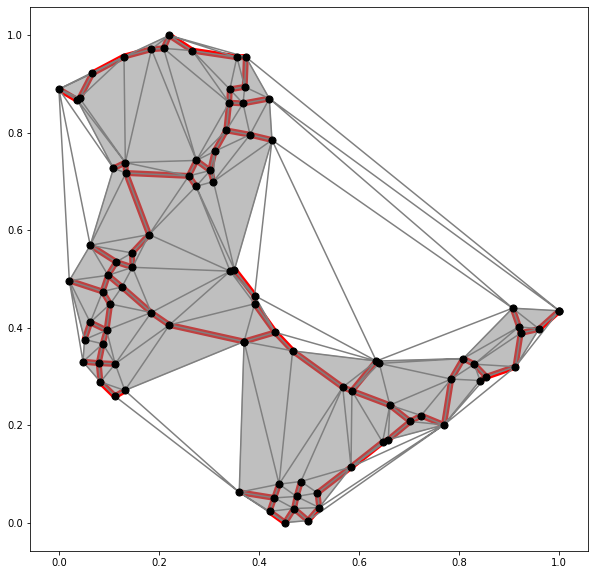

In [23]:

cdict = {1: '#ad494a', 2: '#e69e57', 3: '#14a5b5',4:'#9467bd', 5:'#989aa1',6:'#fff',0:'#fff'}
vis = loadedData[123]
print(vis['sparse_measure'])
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
points = np.array(vis['projects'])
alpha_shape = alphashape.alphashape(points, vis['sparse_measure']*80)
tri = Delaunay(points)
axs.add_patch(PolygonPatch(alpha_shape, alpha=0.5, color="grey"))
axs.triplot(points[:,0], points[:,1], tri.simplices, c="grey")
axs.scatter(points[:,0],points[:,1],50,color='black',zorder=10)
graph = m_mst_graph(vis['projects'])
nx.draw_networkx_edges(graph,vis['projects'],edge_color='red',width=6)


In [24]:
import csv

def load_iris_set():
    with open('iris.csv', newline='') as csvfile:   
        reader = csv.DictReader(csvfile)
        dimensions = []
        classes = []
        for row in reader:
            dimensions.append([float(row['sepallength']), float(row['sepalwidth']), 
                               float(row['petallength']), float(row['petalwidth'])])
            classes.append(row['class'])
        return {'dimensions': dimensions, 'classes': classes}

def load_spotify_set():
    with open('spotify.csv', newline='') as csvfile:   
        reader = csv.DictReader(csvfile)
        dimensions = []
        classes = []
        index = 0
        for row in reader:
            if index%3 == 0:
                dimensions.append([float(row['danceability']), float(row['popularity']), float(row['energy']), 
                                   float(row['acousticness']), float(row['instrumentalness']), 
                                   float(row['liveness']), float(row['valence'])])
                classes.append(row['subgenre'])
            index = index+1
        return {'dimensions': dimensions, 'classes': classes}
    
def load_mnist_set():
    with open('mnist400.csv', newline='') as csvfile:   
        reader = csv.DictReader(csvfile)
        dimensions = []
        classes = []
        for row in reader:
            if int(row['name'])%2 == 0:
                dimensions.append([row[str(i)] for i in range(70,700)])
                classes.append(row['class'])
        return {'dimensions': dimensions, 'classes': classes}
    


def load_random_set():
    randomdumps = []
    classes = [random.randint(1, 5) for i in range(90)]
    dimensions = [[random.random(),random.random()] for i in range(90)]
    return {'dimensions': dimensions, 'classes': classes}

def drawTestGrid(data=[], size=1, m1='lr', m2='perp',classdict={1:1,2:2,3:3}):
    grid = sortInGrid(m1,m2, size, data)
    fig, axs = plt.subplots(size, size, figsize=(25, 25))
    for x in range(0,size):
        for y in range(0,size):
            vis = grid[x][y]
            axs[x, y].scatter([i[0] for i in vis['projects']],[i[1] for i in vis['projects']],
                        s=10,c=[classdict[i] for i in vis['classes']], cmap=plt.get_cmap('Dark2'))
            axs[x, y].set_title("x: "+ str(round(vis[m2],2))+" y:"+ str(round(vis[m1],2)))
            #hausdorff_dist = hausdorff_distance(
            #    np.ndarray(shape=(92,2),buffer=np.array(grid[x][0]['projects'])),
            #    np.ndarray(shape=(92,2),buffer=np.array(vis['projects'])), distance="euclidean")
            #axs[x, y].set_title(round(hausdorff_dist,3))
            #axs[x, y].set_facecolor(str(hausdorff_dist/100))
    for ax in fig.get_axes():
        ax.set_facecolor('#0e0e0e')
        plt.setp(ax.spines.values(), color='grey', linewidth=2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
     

    
def test_datasets_tsne(dataset, perp,lr,i):
    X = np.array(dataset['dimensions'])
    X_embedded = TSNE(n_components=2,perplexity=perp,learning_rate=lr,random_state=i).fit_transform(X)
    X_embedded = preprocessing.minmax_scale(X_embedded)
    return {'name':str(perp)+"_"+str(lr)+str(i),
            'projects':[[float(x[0]),float(x[1])] for x in X_embedded] , 
            'lr': lr,'perp': perp, 'classes':dataset['classes']}


def get_testdataset_dumps(test):
    dumps = []
    for i in range(3,6,2):
        for p in range(3,19):
            for l in range(10,101,10):
                dumps.append(test_datasets_tsne(test,p,l,i))
    testDumps = calculate_all_measures(dumps)  
    print(len(testDumps))
    return testDumps



In [25]:
groesse = 11
m1 = 'tsne_measure'
m2 = 'perp'
filter_m = 'tsne_measure'
randset = load_random_set()
rand_dump = get_testdataset_dumps(randset)
rand_grid = create_new_dump(rand_dump, filter_m)
print(len(rand_grid))
drawTestGrid(data=rand_grid, size=groesse, m1=m1, m2=m2,classdict=[1,2,3,4,5,6,7])



KeyboardInterrupt: 

In [ ]:
groesse = 7
m1 = 'lr'
m2 = 'perp'
filter_m = 'stability_measure'

with open('iris_dump.json') as json_file:
    if json_file:
        iris_dump = json.load(json_file)
    if not iris_dump:
        irisset = load_iris_set()
        iris_dump = get_testdataset_dumps(irisset)
        with open('iris_dump.json','w') as file:
            json.dump(iris_dump,file)  
irisdict={'Iris-versicolor':1,'Iris-setosa':2,'Iris-virginica':3}
iris_grid = create_new_dump(iris_dump,filter_m)
print(len(iris_grid))
drawTestGrid(data=iris_grid, size=groesse, m1=m1, m2=m2,classdict=irisdict)

with open('spotify_dump.json') as json_file:
    if json_file:
        spotify_dump = json.load(json_file)
    if not spotify_dump:
        spotifyset = load_spotify_set()
        spotify_dump = get_testdataset_dumps(spotifyset)
        with open('spotify_dump.json','w') as file:
            json.dump(spotify_dump,file) 
spotifydict={'black metal':1,'death metal':2,'gothic metal':3,'industrial':4,'industrial metal':5,
            'metal':6,'power metal':7,'folk metal':8}
spotify_grid = create_new_dump(spotify_dump, filter_m)
print(len(spotify_grid))
drawTestGrid(data=spotify_grid, size=groesse, m1=m1, m2=m2,classdict=spotifydict)
   
with open('mnist_dump.json') as json_file:
    if json_file:
        mnist_dump = json.load(json_file) 
    if not mnist_dump:
        mnistset = load_mnist_set()
        mnist_dump = get_testdataset_dumps(mnistset)
        with open('mnist_dump.json','w') as file:
            json.dump(mnist_dump,file)    
mnistdict = {str(i):i for i in range(10)}
mnist_grid = create_new_dump(mnist_dump, filter_m)
print(len(mnist_grid))
drawTestGrid(data=mnist_grid, size=groesse, m1=m1, m2=m2,classdict=mnistdict)
    
#with open('../src/assets/current_dump.json') as json_file:
#    loadedData = json.load(json_file)  
loadedData = calculate_all_measures(loadedData)
print(len(loadedData))
drawGrid(data=loadedData, size=groesse, m1=m1, m2=m2)